| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

This notebook is licensed under GPL 3.0. Please visit our [Github repo](https://github.com/edgi-govdata-archiving/ECHO-Cross-Program) for more information.

The notebook was collaboratively authored by EDGI following our [authorship protocol](https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/).

For more information about this project, visit https://www.environmentalenforcementwatch.org/

## How to Run
![Instructions for running a Jupyter Notebook](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/main/overall_instructions.png?raw=true)

## Install `ECHO_modules`

`ECHO_modules` is a "package" of Python programming code that we've written that helps us make some calculations "behind the scenes" so we don't have to clutter this notebook with as much code.

In [ ]:
!pip install ECHO_modules &>/dev/null; # Install the package
import ECHO_modules.utilities # Make styling and mapping functions available
import warnings
warnings.filterwarnings('ignore') # Ignore warnings we already know about
from IPython.core.display import HTML # To make output pretty

##Pick a County/State to focus on

In [151]:
# Select the place...
from ECHO_modules.utilities import show_pick_region_widget, show_state_widget

state_widget = show_state_widget()

Dropdown(description='State:', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI'…

In [156]:
county_widget = show_pick_region_widget(type="County", state_widget=state_widget, multi=False)

Dropdown(description='County:', options=('ADAMS', 'ALAMOSA', 'ANNE ARUNDEL', 'ARAPAHOE', 'ARCHULETA', 'BACA', …

## See the watersheds that intersect with this county and the facilities regulated under National Pollutant Discharage Elimination System (NPDES) within them

There are two issues to keep in mind here:
1. We are unable to lookup watersheds for some counties because of discrepancies in how EPA labels them and how USGS maps them.
2. Some watersheds are home to many thousands of facilities. Due to technical limitations, we may not be able to map them all. We map a sample of as many as possible in order to give a sense of their distribution across the watershed.

In [ ]:
import geopandas
from ECHO_modules.get_data import get_spatial_data
from ECHO_modules.geographies import spatial_tables
from ECHO_modules.utilities import bivariate_map
from ECHO_modules.utilities import get_active_facilities
from ECHO_modules.make_data_sets import make_data_sets
from urllib.error import HTTPError # Known error - unable to get info from database

# For handling database errors
## From: https://stackoverflow.com/questions/24005221/ipython-notebook-early-exit-from-cell
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

# Get spatial data
county, state = get_spatial_data(region_type="County", states=[state_widget.value], spatial_tables=spatial_tables, region_filter=[county_widget.value.title()])
watersheds, state = get_spatial_data(region_type="Watershed", states=[state_widget.value], spatial_tables=spatial_tables)
watersheds = watersheds.loc[watersheds.intersects(county)]

# Get facilities in this watershed/s
try:
  data_sets = make_data_sets(["Facilities"])
  program = data_sets["Facilities"]
  this_watersheds_facs = program.store_results(region_type="Watershed", region_value=','.join([str(w) for w in watersheds["huc8"].unique()]), state=state_widget.value)
  this_watersheds_facs.dataframe = this_watersheds_facs.dataframe[this_watersheds_facs.dataframe["NPDES_FLAG"]=="Y"] # Filter to NPDES
  this_watersheds_facs.dataframe
except HTTPError:
  print("Unfortunately, we can't access information for that county's watershed(s) right now.")
  raise StopExecution

# Get permit numbers for facilities in this watershed/s
pgm_ids = list(set([a for b in this_watersheds_facs.dataframe["NPDES_IDS"].str.split(" ", expand=False).tolist() for a in b]))

# Map
pts = geopandas.GeoDataFrame(this_watersheds_facs.dataframe, geometry=geopandas.points_from_xy(this_watersheds_facs.dataframe['FAC_LONG'], this_watersheds_facs.dataframe['FAC_LAT'], crs="4269"))
bivariate_map(regions=watersheds, points=pts.sample(5000), region_fields=["name"], region_aliases=["Watershed: "], points_fields=['FAC_NAME',], points_aliases=['Facility: ',])

## Find details on NPDES permits across the country
Each row in the table that follows will indicate a unique parameter/reporting time frame/permit limit combination e.g. "Solids, total dissolved - reported once a week (01/07) - an enforceable permit to be under or equal to 5000 mg/L". See the spreadsheet [here](https://echo.epa.gov/system/files/REF_FREQUENCY_OF_ANALYSIS.csv) for an explanation of the frequency codes.

NOTE: We are focusing on active permits, as well as those that EPA has recorded a numerical limit for. There are nearly 3 million (!) permits that have no information about limit values.

In [158]:
from ECHO_modules.get_data import get_echo_data
# More info on NPDES_LIMITS here: https://echo.epa.gov/tools/data-downloads/icis-npdes-limit-summary
sql ='SELECT "EXTERNAL_PERMIT_NMBR", "PARAMETER_DESC", "LIMIT_FREQ_OF_ANALYSIS_CODE", "LIMIT_UNIT_DESC", '+\
    '"LIMIT_VALUE_QUALIFIER_CODE", "LIMIT_TYPE_CODE", "LIMIT_VALUE_NMBR" from "NPDES_LIMITS" where '+\
    '"LIMIT_SET_STATUS_FLAG" = \'A\' and "VERSION_NMBR" = 0 and "LIMIT_VALUE_NMBR" is not Null' # ignoring 2,809,028 null limit values!!!!
permits = get_echo_data(sql)
display(HTML("<h2>Active NPDES permits with available information</h2>"))
permits

EXTERNAL_PERMIT_NMBR                  PARAMETER_DESC  \
0                  AK0000272                              pH   
1                  AK0000272                              pH   
2                  AK0000272                              pH   
3                  AK0000272        Chlorine, total residual   
4                  AK0000272        Chlorine, total residual   
...                      ...                             ...   
2589542            WYG740747         Solids, total dissolved   
2589543            WYG740814         Solids, total dissolved   
2589544            WYG740820  Produced water, oil and grease   
2589545            WYR000723             Iron, total [as Fe]   
2589546            WYR001232         Iron, total recoverable   

        LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC  \
0                             01/07              SU   
1                             01/07              SU   
2                             01/07              SU   
3                             01/07            mg/L   
4                             01/07            mg/L   
...                             ...             ...   
2589542                       01/07            mg/L   
2589543                       01/07            mg/L   
2589544                       01/01            mg/L   
2589545                       01/YR            mg/L   
2589546                       01/YR            mg/L   

        LIMIT_VALUE_QUALIFIER_CODE LIMIT_TYPE_CODE  LIMIT_VALUE_NMBR  
0                               <=             ENF               8.5  
1                               >=             ENF               6.5  
2                               <=             ENF               8.5  
3                               <=             ENF               0.1  
4                               <=             ENF               0.1  
...                            ...             ...               ...  
2589542                         <=             ENF            5000.0  
2589543                         <=             ENF            5000.0  
2589544                         <=             ENF              10.0  
2589545                         <=             ALR               1.0  
2589546                         <=             ALR               1.0  

[2589547 rows x 7 columns]

Next, we group these permits by parameter, frequency of measurement, limit type (enforceable / not-enforceable), and summarize the mean and median permit values, and sort based on the number of permits this applies to. We show the top 10 parameter/monitoring frequency/type combinations in terms of number of applicable permits.

In [159]:
display(HTML("<h2>Top ten NPDES permit types</h2>"))
permits.groupby(["PARAMETER_DESC", "LIMIT_FREQ_OF_ANALYSIS_CODE", "LIMIT_UNIT_DESC",
              "LIMIT_TYPE_CODE", "LIMIT_VALUE_QUALIFIER_CODE"])[["LIMIT_VALUE_NMBR"]].agg(
                                ["mean", "median", "count"]).sort_values(
                                by=('LIMIT_VALUE_NMBR',"count"), ascending=False
                                ).head(10)

LIMIT_VALUE_NMBR  \
                                                                                                                            mean   
PARAMETER_DESC           LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE                    
Solids, total suspended  02/30                       mg/L            ENF             <=                                53.774132   
                         01/07                       mg/L            ENF             <=                                44.062404   
pH                       02/30                       SU              ENF             <=                                 9.017661   
                                                                                     >=                              7318.271906   
Iron, total [as Fe]      02/30                       mg/L            ENF             <=                                 3.229752   
Solids, total suspended  01/30                       mg/L            ENF             <=                                51.702028   
Manganese, total [as Mn] 02/30                       mg/L            ENF             <=                                 2.881734   
pH                       01/30                       SU              ENF             >=                             26180.347616   
                                                                                     <=                                 8.904233   
                         01/07                       SU              ENF             >=                              3005.608006   

                                                                                                                        \
                                                                                                                median   
PARAMETER_DESC           LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE          
Solids, total suspended  02/30                       mg/L            ENF             <=                          40.00   
                         01/07                       mg/L            ENF             <=                          45.00   
pH                       02/30                       SU              ENF             <=                           9.00   
                                                                                     >=                           6.00   
Iron, total [as Fe]      02/30                       mg/L            ENF             <=                           2.46   
Solids, total suspended  01/30                       mg/L            ENF             <=                          40.00   
Manganese, total [as Mn] 02/30                       mg/L            ENF             <=                           2.00   
pH                       01/30                       SU              ENF             >=                           6.00   
                                                                                     <=                           9.00   
                         01/07                       SU              ENF             >=                           6.50   

                                                                                                                        
                                                                                                                 count  
PARAMETER_DESC           LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE         
Solids, total suspended  02/30                       mg/L            ENF             <=                          78115  
                         01/07                       mg/L            ENF             <=                          49224  
pH                       02/30                       SU              ENF             <=                          41193  
                                                                                  

Run the following cell of code and then select a pollutant/parameter to focus on it specifically.

In [160]:
import ipywidgets as widgets

pollutant = widgets.Dropdown(
    options=list(permits["PARAMETER_DESC"].sort_values().unique()),
    description='Pollutant:',
    disabled=False,
)
pollutant

Dropdown(description='Pollutant:', options=('% Effect Static Chronic Arbacia punctulata', '% Effect Static Ren…

In [161]:
# Focus on one of these e.g. lead
this_pollutant_permits = permits.loc[permits["PARAMETER_DESC"]==pollutant.value] # .str.lower().str.contains("lead")
## Group by reporting frequency, units, direction (greater/less than), and enforceability
display(HTML("<h2>Top ten NPDES permit types for "+pollutant.value+"</h2>"))
this_pollutant_permits.groupby(["LIMIT_FREQ_OF_ANALYSIS_CODE", "LIMIT_UNIT_DESC",
              "LIMIT_TYPE_CODE", "LIMIT_VALUE_QUALIFIER_CODE"])[["LIMIT_VALUE_NMBR"]].agg(
                                ["sum", "mean", "median", "count"]).sort_values(
                                by=('LIMIT_VALUE_NMBR',"count"), ascending=False
                                ).head(10)

LIMIT_VALUE_NMBR  \
                                                                                                    sum   
LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE                    
01/30                       mg/L            ENF             <=                                    0.800   
01/14                       mg/L            ENF             <=                                    0.258   
01/30                       ug/L            ALR             <=                                  144.000   
01/EV                       mg/L            ENF             <=                                    0.300   
01/01                       ug/L            ENF             <=                                   40.000   
01/07                       ug/kg           ENF             <=                                  490.000   
01/6M                       mg/L            ENF             <=                                   10.010   
01/30                       ug/L            ENF             <=                                    5.000   
01/90                       mg/L            ENF             <=                                    0.010   

                                                                                                    \
                                                                                              mean   
LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE               
01/30                       mg/L            ENF             <=                            0.114286   
01/14                       mg/L            ENF             <=                            0.064500   
01/30                       ug/L            ALR             <=                           48.000000   
01/EV                       mg/L            ENF             <=                            0.100000   
01/01                       ug/L            ENF             <=                           20.000000   
01/07                       ug/kg           ENF             <=                          245.000000   
01/6M                       mg/L            ENF             <=                            5.005000   
01/30                       ug/L            ENF             <=                            5.000000   
01/90                       mg/L            ENF             <=                            0.010000   

                                                                                                  \
                                                                                          median   
LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE             
01/30                       mg/L            ENF             <=                            0.1000   
01/14                       mg/L            ENF             <=                            0.0645   
01/30                       ug/L            ALR             <=                           48.0000   
01/EV                       mg/L            ENF             <=                            0.1000   
01/01                       ug/L            ENF             <=                           20.0000   
01/07                       ug/kg           ENF             <=                          245.0000   
01/6M                       mg/L            ENF             <=                            5.0050   
01/30                       ug/L            ENF             <=                            5.0000   
01/90                       mg/L            ENF             <=                            0.0100   

                                                                                              
                                                                                       count  
LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE        
01/30                       mg/L            ENF             <=                             

Now let's focus on what's going on in the watershed(s) that criss-cross our selected county. Again, we'll show the top 10 parameters/pollutants in terms of number of permits required to monitor/stay within a limit on them.



In [162]:
# Focus on this watershed/s by filtering to permits in this watershed/s
these_permits = permits[permits['EXTERNAL_PERMIT_NMBR'].isin(pgm_ids)]
# Show overall
display(HTML("<h2>Top ten NPDES permit types in the selected watershed(s)</h2>"))
these_permits.groupby(["PARAMETER_DESC", "LIMIT_FREQ_OF_ANALYSIS_CODE", "LIMIT_UNIT_DESC",
              "LIMIT_TYPE_CODE", "LIMIT_VALUE_QUALIFIER_CODE"])[["LIMIT_VALUE_NMBR"]].agg(
                                ["sum", "mean", "median", "count"]).sort_values(
                                by=('LIMIT_VALUE_NMBR',"count"), ascending=False
                                ).head(10)

LIMIT_VALUE_NMBR  \
                                                                                                                                             sum   
PARAMETER_DESC                           LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE                    
Solids, total suspended                  01/07                       mg/L            ENF             <=                             2.150150e+05   
Oil and grease                           77/77                       mg/L            ENF             <=                             4.019480e+04   
Nitrogen, ammonia total [as N]           01/07                       mg/L            ENF             <=                             1.098756e+05   
pH                                       01/07                       SU              ENF             <=                             2.871950e+04   
                                                                                                     >=                             2.076250e+04   
Flow, in conduit or thru treatment plant 01/07                       gal/min         ENF             <=                             2.008297e+06   
                                         01/99                       MGD             ENF             <=                             1.069254e+03   
                                         99/99                       MGD             ENF             <=                             2.313228e+03   
E. coli                                  01/07                       #/100mL         ENF             <=                             1.551977e+05   
Benzene                                  01/07                       ug/L            ENF             <=                             1.595039e+06   

                                                                                                                                              \
                                                                                                                                        mean   
PARAMETER_DESC                           LIMIT_FREQ_OF_ANALYSIS_CODE LIMIT_UNIT_DESC LIMIT_TYPE_CODE LIMIT_VALUE_QUALIFIER_CODE                
Solids, total suspended                  01/07                       mg/L            ENF             <=                            37.748420   
Oil and grease                           77/77                       mg/L            ENF             <=                             9.998706   
Nitrogen, ammonia total [as N]           01/07                       mg/L            ENF             <=                            31.073416   
pH                                       01/07                       SU              ENF             <=                             8.974844   
                                                                                                     >=                             6.488281   
Flow, in conduit or thru treatment plant 01/07                       gal/min         ENF             <=                          1424.323972   
                                         01/99                       MGD             ENF             <=                             1.520987   
                                         99/99                       MGD             ENF             <=                             3.569796   
E. coli                                  01/07                       #/100mL         ENF             <=                           278.631418   
Benzene                                  01/07                       ug/L            ENF             <=                          2915.976782   

                                                                                                                                              \
                                                                                                                                      median   
PARAMETER_DESC                           L

The next cell will show us what the selected parameter/pollutant looks like in this watershed. (To pick a different parameter/pollutant, return to that dropdown menu and select something else)

In [163]:
# Focus on one of these e.g. lead
this_watershed_polls = these_permits.loc[these_permits["PARAMETER_DESC"]==pollutant.value] # .str.lower().str.contains("lead")
## Group by reporting frequency, units, direction (greater/less than), and enforceability
display(HTML("<h2>Top ten NPDES permit types for "+pollutant.value+" in this watershed(s)</h2>"))
this_watershed_polls.groupby(["LIMIT_FREQ_OF_ANALYSIS_CODE", "LIMIT_UNIT_DESC",
              "LIMIT_TYPE_CODE", "LIMIT_VALUE_QUALIFIER_CODE"])[["LIMIT_VALUE_NMBR"]].agg(
                                ["mean", "median", "count"]).sort_values(
                                by=('LIMIT_VALUE_NMBR',"count"), ascending=False
                                ).head(10)

Empty DataFrame
Columns: [(LIMIT_VALUE_NMBR, mean), (LIMIT_VALUE_NMBR, median), (LIMIT_VALUE_NMBR, count)]
Index: []

## Examine permit exceedences in Fiscal Year 2022.
We'll look at which permits were recorded as exceeded in FY 2022 (October 2021 - September 2022). That's a few years ago now - this is a limitation of our database and technical capacity more than anything else.

NOTE: These are exceedences recorded by EPA and triggered by facilities' "discharge monitoring reports" (DMRs). If a DMR indicates a pollutant/parameter was measured at a level exceeding the permit, an exceedence may be flagged (and, eventually, a violation). However, we have documented how many facilities do not regularly submit DMRs, meaning that there may exceedences that occurred but are not recorded here.

In [164]:
params = ["FAC_DERIVED_HUC", "EXTERNAL_PERMIT_NMBR", "FAC_NAME", "PARAMETER_DESC", "DMR_VALUE_STANDARD_UNITS", "LIMIT_VALUE_STANDARD_UNITS", "EXCEEDANCE_PCT", "STANDARD_UNIT_DESC"]
sql = 'select {} from "DMR_FY2022_MVIEW" where "EXCEEDANCE_PCT" is not Null'.format(",".join(['\"'+p+'\"' for p in params]))
dmrs = get_echo_data(sql)
display(HTML("<h2>Nationwide permit exceedances for FY2022</h2>"))
dmrs

FAC_DERIVED_HUC EXTERNAL_PERMIT_NMBR  \
0             2030105.0            NJ0023663   
1             2030105.0            NJ0023663   
2             2030105.0            NJ0021865   
3             2030105.0            NJ0021865   
4             2040202.0            NJ0004383   
...                 ...                  ...   
154998       17010203.0            MTX000235   
154999        3030002.0            NC0045128   
155000       17010208.0            MT0021938   
155001       17010208.0            MT0021938   
155002        3010205.0            NC0048861   

                                          FAC_NAME  \
0                               CARRIER FOUNDATION   
1                               CARRIER FOUNDATION   
2                   FIDDLER'S ELBOW CTRY CLUB WWTP   
3                   FIDDLER'S ELBOW CTRY CLUB WWTP   
4               BUCKEYE PENNSAUKEN TERMINAL (HESS)   
...                                            ...   
154998  KETTLEHOUSE BREWING CO - BONNER BREW HOUSE   
154999           ALAMANCE-BURLINGTON SCHOOL SYSTEM   
155000                      CITY OF KALISPELL WWTP   
155001                      CITY OF KALISPELL WWTP   
155002                               CRESWELL WWTP   

                               PARAMETER_DESC  DMR_VALUE_STANDARD_UNITS  \
0                    Phosphorus, total [as P]                  1.200000   
1                    Phosphorus, total [as P]                  1.700000   
2                  Arsenic, total recoverable                  0.005000   
3                  Arsenic, total recoverable                  0.005000   
4                     Solids, total suspended                 55.000000   
...                                       ...                       ...   
154998                 Nitrogen, total [as N]                  3.395920   
154999  Coliform, fecal MF, MFC broth, 44.5 C               2420.000000   
155000                  BOD, 5-day, 20 deg. C                118.403199   
155001                  BOD, 5-day, 20 deg. C                241.073998   
155002                Solids, total suspended                 47.000000   

        LIMIT_VALUE_STANDARD_UNITS  EXCEEDANCE_PCT STANDARD_UNIT_DESC  
0                         1.000000              20               mg/L  
1                         1.000000              70               mg/L  
2                         0.003500              43               mg/L  
3                         0.003500              43               mg/L  
4                        50.000000              10               mg/L  
...                            ...             ...                ...  
154998                    0.835360             307               kg/d  
154999                  400.000000             505          MPN/100mL  
155000                  117.585999               1               kg/d  
155001                  176.151999              37               kg/d  
155002                   45.000000               4               mg/L  

[155003 rows x 8 columns]

Summarize exceedences in terms of the number of times a given parameter/pollutant was found to be in excess of a permitted level. We show the top 10. We also indicate the median percent those measurements exceeded permitted levels.

In [165]:
# Summarize
display(HTML("<h2>Top ten pollutants released in excess of permitted values - nationwide FY2022</h2>"))
display(dmrs.groupby(by="PARAMETER_DESC")[["EXCEEDANCE_PCT"]].agg(["median", "count"]).sort_values(by=("EXCEEDANCE_PCT", "count"), ascending=False).head(10))

display(HTML("<h2>Top ten pollutants released in excess of permitted values - in the selected watershed(s) FY2022</h2>"))
these_dmrs = dmrs[dmrs["FAC_DERIVED_HUC"].isin(list(watersheds["huc8"].unique()))]
display(these_dmrs.groupby(by="PARAMETER_DESC")[["EXCEEDANCE_PCT"]].agg(["median", "count"]).sort_values(by=("EXCEEDANCE_PCT", "count"), ascending=False).head(10))

EXCEEDANCE_PCT       
                                          median  count
PARAMETER_DESC                                         
Solids, total suspended                     60.0  30173
Nitrogen, ammonia total [as N]             115.0  24592
BOD, 5-day, 20 deg. C                       60.0  13010
Coliform, fecal general                    820.0  10885
BOD, carbonaceous [5 day, 20 C]             60.0   8656
E. coli                                    496.0   6583
Chlorine, total residual                   221.0   4905
Oxygen, dissolved [DO]                      26.0   4576
Phosphorus, total [as P]                    54.0   3710
Solids, suspended percent removal           69.0   2887

EXCEEDANCE_PCT      
                                                 median count
PARAMETER_DESC                                               
Solids, total suspended                            50.0    69
Selenium, potentially dissolvd                    140.0    48
Flow, in conduit or thru treatment plant           41.5    28
Nitrogen, ammonia total [as N]                     80.5    20
Iron, total [as Fe]                               125.0    18
BOD, 5-day, 20 deg. C                              27.0    17
Chloroform                                         42.5    14
Solids, suspended percent removal                 113.0    13
Nitrite + Nitrate total [as N]                    103.0    13
Aluminum, total [as Al]                           126.5    10

## Get water quality violations
As mentioned, permit exceedences can result in EPA/state agencies determining the permit holder has caused an "effluent violation" which can ultimately lead the facility to be deemed in "non-compliance."

Here, we examine the number of effluent violations over time, summarized at the watershed (`FAC_DERIVED_HUC`) scale. Going back to 2001, we show the top 10 watersheds and years in terms of the violation rate (`rate_per_100_fac`): the number of effluent violations logged per 100 permits found to be in violation. This gives us a measure of "watersheds with especially bad actors." `sum` = the number of violations in that watershed that year, `count` = the number of facilities found in violation.

For the selected county, we show each year's violation rates.

sum  count  rate_per_100_fac
FAC_DERIVED_HUC YEAR                              
17020002        2020  580      1           58000.0
                2019  550      1           55000.0
                2018  546      1           54600.0
                2016  524      1           52400.0
                2015  479      1           47900.0
                2017  451      1           45100.0
                2023  554      2           27700.0
18070305        2003  207      1           20700.0
                2005  189      1           18900.0
15050201        2017  182      1           18200.0

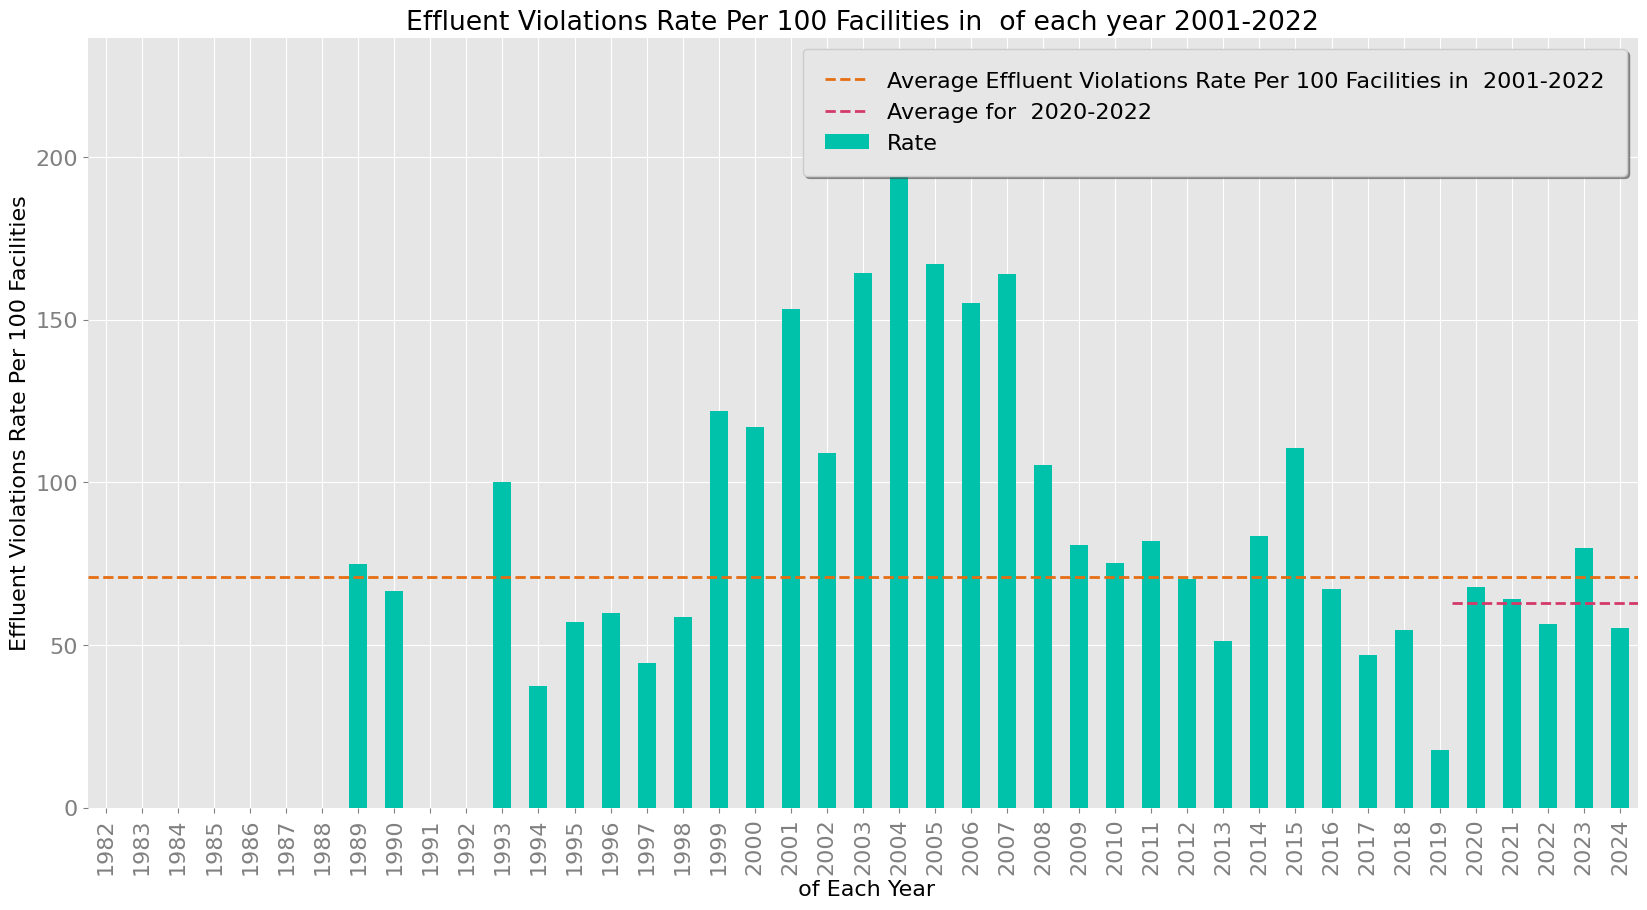

In [149]:
# Get data
sql = 'select "FAC_DERIVED_HUC", "YEARQTR", count(distinct("NPDES_ID")) from "WATER_QUARTERLY_VIOLATIONS_MVIEW" group by "FAC_DERIVED_HUC", "YEARQTR"' # where cast("YEARQTR" as text) like \'2023%\'
violations_count = get_echo_data(sql)
sql = 'select "FAC_DERIVED_HUC", "YEARQTR", sum("NUME90Q") from "WATER_QUARTERLY_VIOLATIONS_MVIEW" group by "FAC_DERIVED_HUC", "YEARQTR"' # where cast("YEARQTR" as text) like \'2023%\'
violations_sum = get_echo_data(sql)

# Data processing
violations = violations_count.merge(violations_sum, on=["FAC_DERIVED_HUC", "YEARQTR"])
violations["YEAR"] = violations["YEARQTR"].astype(str).str.slice(0,4)
violations["FAC_DERIVED_HUC"] = violations["FAC_DERIVED_HUC"].astype(str)
violations["FAC_DERIVED_HUC"] = violations["FAC_DERIVED_HUC"].str.replace(".0", "") # remove remanants of float
violations.loc[violations["FAC_DERIVED_HUC"].str.len() == int(8)-1, "FAC_DERIVED_HUC"] = "0" + violations["FAC_DERIVED_HUC"]

# Summarize
violations_summarized = violations.groupby(by=["FAC_DERIVED_HUC","YEAR"])[["sum", "count"]].agg({"sum":"sum", "count": "max"}) # Max = at least this many facilities in violation...
violations_summarized["rate_per_100_fac"] = 100 * (violations_summarized["sum"]/violations_summarized["count"])

# Display table
display(HTML("<h2>Top ten watersheds/years nationwide for effluent violations</h2>"))
display(violations_summarized.sort_values(by=["rate_per_100_fac"], ascending=False).head(10))

# Display chart
from ECHO_modules.utilities import chart
import pandas
display(HTML("<h2>Effluent violations over time in the selected watershed(s)</h2>"))
to_chart = violations_summarized.reset_index()
to_chart = to_chart[to_chart["FAC_DERIVED_HUC"].isin(list(watersheds["huc8"].astype(str).unique()))]
to_chart["YEAR"] = pandas.to_datetime(to_chart["YEAR"])
chart(to_chart, "YEAR", "rate_per_100_fac", "Rate", "sum", "Effluent Violations Rate Per 100 Facilities")

Next, we map the *current* (2023) top ten watersheds in terms of water quality violations. Darker shades indicate higher rates of violations (per facility in violation).

In [ ]:
import geopandas
current = violations_summarized.reset_index()
current = current.loc[current["YEAR"]=="2023"].drop_duplicates(subset=["FAC_DERIVED_HUC"]).sort_values(by=["rate_per_100_fac"], ascending=False).head(10)
sql = 'SELECT * FROM "wbdhu8" where "huc8" in ({})'.format(','.join(["\'"+str(w)+"\'" for w in list(current["FAC_DERIVED_HUC"].unique())]))
these_watersheds = get_echo_data(sql)
these_watersheds['geometry'] = geopandas.GeoSeries.from_wkb(these_watersheds['wkb_geometry'])
these_watersheds.drop("wkb_geometry", axis=1, inplace=True)
these_watersheds = geopandas.GeoDataFrame(these_watersheds, crs=4269)

these_watersheds.loc[these_watersheds["huc8"].astype(str).str.len() == 7, "huc8"] = "0" + these_watersheds["huc8"].astype(str)
these_watersheds["huc8"] = these_watersheds["huc8"].astype(str)
current.reset_index(inplace=True)
current["FAC_DERIVED_HUC"] = current["FAC_DERIVED_HUC"].astype(str)
these_watersheds = these_watersheds.merge(current, left_on="huc8", right_on="FAC_DERIVED_HUC")#.drop_duplicates(subset=["FAC_DERIVED_HUC"]).sort_values(by=["rate_per_100_fac"], ascending=False).head(10),

from ECHO_modules.utilities import choropleth
choropleth(these_watersheds, attribute="rate_per_100_fac", key_id="name")

# Who is responsible for effluent violations?
A pattern of effluent or other NPDES violations can lead a facility to be deemed "non-compliant." Here we look at the past 13 quarters (~3 years) of compliance by regulated facilities in the watershed(s) that intersect with the selected county.

We show a selection of the top 100 most non-compliant facilities - there may be more with an equal number of non-compliant quarters.

In [107]:
from ECHO_modules.utilities import get_top_violators, chart_top_violators, bivariate_map
violators = get_top_violators( this_watersheds_facs.dataframe, 'NPDES_FLAG',
            'CWA_13QTRS_COMPL_HISTORY', 'CWA_FORMAL_ACTION_COUNT', 100 )
bivariate_map(watersheds, geopandas.GeoDataFrame(violators,
                                                 geometry=geopandas.points_from_xy(x=violators["FAC_LONG"], y=violators["FAC_LAT"], crs=4269)
                                                 ),
              region_fields=['name',], region_aliases=['Watershed name: ',],
              points_fields=['FAC_NAME',], points_aliases=['Facility name: ',])

## What does enforcement look like?

EPA and state agencies can make inspections and take enforcement actions (written orders, penalties, etc.) against facilities in the hopes of resolving non-compliance and ensuring compliance. To what extent does that appear to be happening?

We show what inspections, enforcements, and penalties look like in watersheds nationwide (ranked in terms of the enforcement rate per 100 facilities actions taken against) and locally.


In [109]:
# Get data
sql = 'select "FAC_DERIVED_HUC", count(distinct("NPDES_ID")) as differentfac_ins, count("NPDES_ID") as inspections from "CLEAN_WATER_INSPECTIONS_MVIEW" group by "FAC_DERIVED_HUC"'
inspections = get_echo_data(sql)
sql = 'select "FAC_DERIVED_HUC", sum("FED_PENALTY_ASSESSED_AMT") as dollars from "CLEAN_WATER_ENFORCEMENT_ACTIONS_MVIEW" group by "FAC_DERIVED_HUC"' # where cast("YEARQTR" as text) like \'2023%\'
penalties = get_echo_data(sql)
sql = 'select "FAC_DERIVED_HUC", count(distinct("NPDES_ID")) as differentfac_enf, count("NPDES_ID") as actions from "CLEAN_WATER_ENFORCEMENT_ACTIONS_MVIEW" group by "FAC_DERIVED_HUC"' # where cast("YEARQTR" as text) like \'2023%\'
enf = get_echo_data(sql)

# Process
enforcement = inspections.merge(penalties, on="FAC_DERIVED_HUC").merge(enf, on="FAC_DERIVED_HUC")
enforcement["FAC_DERIVED_HUC"] = enforcement["FAC_DERIVED_HUC"].astype(str)
enforcement["FAC_DERIVED_HUC"] = enforcement["FAC_DERIVED_HUC"].str.replace(".0", "") # remove remanants of float
enforcement.loc[enforcement["FAC_DERIVED_HUC"].str.len() == int(8)-1, "FAC_DERIVED_HUC"] = "0" + enforcement["FAC_DERIVED_HUC"]

# Summarize
enforcement["inspection_rate_per_100"] = 100 * (enforcement['inspections'] / enforcement['differentfac_ins'])
enforcement["enforcement_rate_per_100"] = 100 * (enforcement['actions'] / enforcement['differentfac_enf'])

# Display
display(HTML("<h2>NPDES enforcement rate nationwide (2001-present)</h2>"))
display(enforcement.sort_values(by="enforcement_rate_per_100", ascending=False).fillna(0)) # Assume NaNs are 0s

display(HTML("<h2>NPDES enforcement rate in the selected watershed(s) (2001-present)</h2>"))
display(enforcement[enforcement["FAC_DERIVED_HUC"].isin(list(watersheds["huc8"].astype(str).unique()))].fillna(0)) # Assume NaNs are 0s

FAC_DERIVED_HUC  differentfac_ins  inspections   dollars  \
172         03040104                53          446       0.0   
167         03030006                80          459   27000.0   
149         03010203                30           92       0.0   
164         03030003               269         1861   62000.0   
1682        18060010                15          102       0.0   
...              ...               ...          ...       ...   
1248        12090101                 5           14  483064.0   
1244        12080004                 5            8       0.0   
1243        12080003                12           16       0.0   
1223        12050007                 6            8       0.0   
882         10120104                30          184       0.0   

      differentfac_enf  actions  inspection_rate_per_100  \
172                  9      227               841.509434   
167                  9      206               573.750000   
149                  5      104               306.666667   
164                 37      697               691.821561   
1682                 1       18               680.000000   
...                ...      ...                      ...   
1248                 2        2               280.000000   
1244                 2        2               160.000000   
1243                 9        9               133.333333   
1223                 4        4               133.333333   
882                  1        1               613.333333   

      enforcement_rate_per_100  
172                2522.222222  
167                2288.888889  
149                2080.000000  
164                1883.783784  
1682               1800.000000  
...                        ...  
1248                100.000000  
1244                100.000000  
1243                100.000000  
1223                100.000000  
882                 100.000000  

[1765 rows x 8 columns]

FAC_DERIVED_HUC  differentfac_ins  inspections   dollars  \
934        10190003              1419         3201  702538.0   

     differentfac_enf  actions  inspection_rate_per_100  \
934               160      318               225.581395   

     enforcement_rate_per_100  
934                    198.75

Next, we'll map out the top ten watersheds in terms of the rate of enforcement actions recorded against facilities with penalties, written orders, or other issues (out of 100)

In [114]:
import geopandas
sql = 'SELECT * FROM "wbdhu8" where "huc8" in ({})'.format(','.join(["\'"+str(w)+"\'" for w in list(enforcement.sort_values(by="enforcement_rate_per_100", ascending=False).head(10)["FAC_DERIVED_HUC"].unique())]))
these_watersheds = get_echo_data(sql)
these_watersheds['geometry'] = geopandas.GeoSeries.from_wkb(these_watersheds['wkb_geometry'])
these_watersheds.drop("wkb_geometry", axis=1, inplace=True)
these_watersheds = geopandas.GeoDataFrame(these_watersheds, crs=4269)

these_watersheds.loc[these_watersheds["huc8"].astype(str).str.len() == 7, "huc8"] = "0" + these_watersheds["huc8"].astype(str)
these_watersheds = these_watersheds.merge(enforcement.sort_values(by="enforcement_rate_per_100", ascending=False).head(10), left_on="huc8", right_on="FAC_DERIVED_HUC")

from ECHO_modules.utilities import choropleth
choropleth(these_watersheds, attribute="enforcement_rate_per_100", key_id="name")

## What does all this mean in terms of water quality outcomes locally?
We try to access EPA's ATTAINS database to report on water quality conditions in the selected county's watershed(s).

ATTAINS gives us granular information on HUC12-level watersheds - these are smaller than the HUC8 watersheds we have been looking at so far.

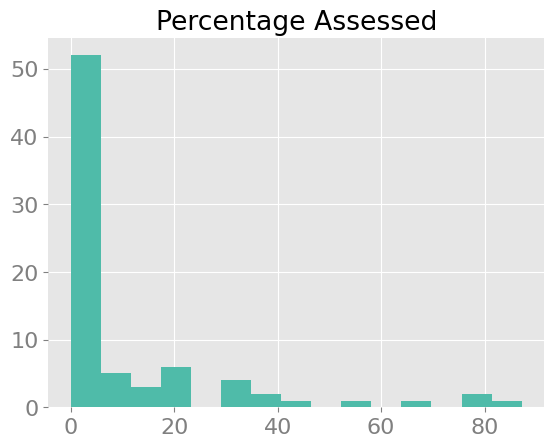

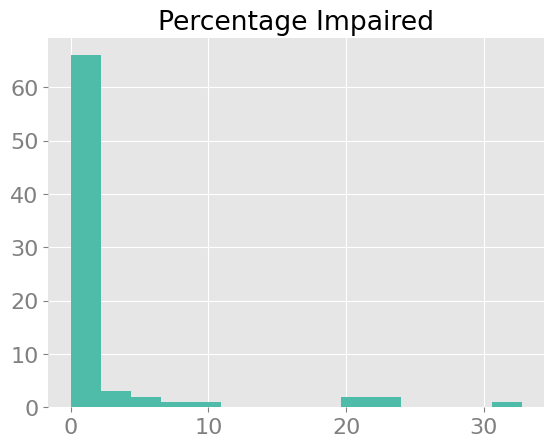

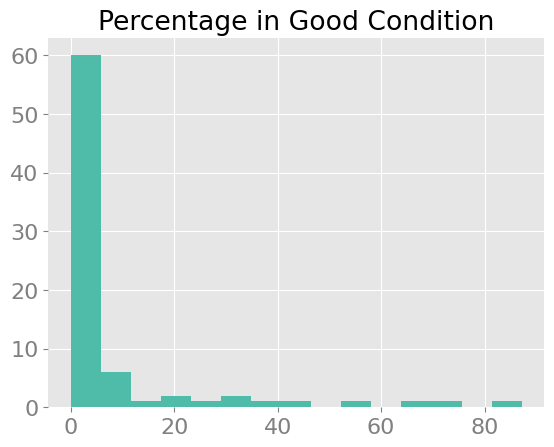

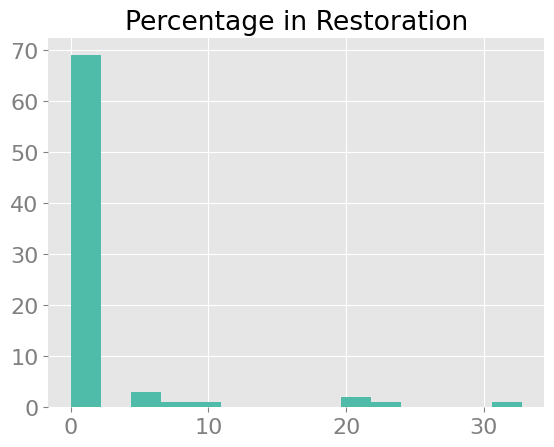

In [144]:
import requests
import json

# First, find huc12s in our huc8s
sql = 'SELECT * FROM "wbdhu12" where "huc12" like any (array[{}])'.format(','.join(["\'"+str(w)+"%\'" for w in list(watersheds["huc8"].unique())]))
watersheds_12 = get_echo_data(sql)
watersheds_12

# Now, look up ATTAINS info
ws = list(watersheds_12["huc12"].unique())
attains = []

for w in ws:
  url = "https://attains.epa.gov/attains-public/api/huc12summary?huc=" + str(w)
  response = requests.get(url)
  attains.append(response.json())

to_chart = []
for w in attains:
  huc = w["items"][0]["huc12"]
  assessed = w["items"][0]["assessedCatchmentAreaPercent"]
  impaired = w["items"][0]["containImpairedWatersCatchmentAreaPercent"]
  good = w["items"][0]["assessedGoodCatchmentAreaPercent"]
  restoration = w["items"][0]["containRestorationCatchmentAreaPercent"]
  to_chart.append({"Watershed": huc, "Percentage Assessed": assessed, "Percentage Impaired": impaired, "Percentage in Good Condition": good, "Percentage in Restoration": restoration})

to_chart = pandas.DataFrame.from_records(to_chart)

# Display charts of results
to_chart.sort_values(by="Percentage Assessed", ascending=False)
for c in to_chart.columns:
  if c != "Watershed":
    to_chart[[c]].hist(bins=15)

# Display map of results
watersheds_12["huc12"] = watersheds_12["huc12"].astype(str)
to_map = pandas.merge(to_chart, watersheds_12, left_on="Watershed", right_on="huc12")
to_map['geometry'] = geopandas.GeoSeries.from_wkb(to_map['wkb_geometry'])
to_map.drop("wkb_geometry", axis=1, inplace=True)
to_map = geopandas.GeoDataFrame(to_map, crs=4269)
choropleth(polygons=to_map[to_map["Percentage Assessed"] > 0], attribute="Percentage Impaired", key_id="name", legend_name="Percentage of Assessed Watershed Impaired")